In [33]:
import pandas as pd
import seaborn as sb
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [34]:
data = joblib.load("phabsummary_5bp.jl")

In [35]:
# How many regions are we looking at?
print(len(data))

32088


In [36]:
rows = []
n_failed = 0
for k,reg in data.items():
    try:
        rows.append([k, reg['in']['var_count'], reg['out']['var_count'], 
                     reg['in']['var_positions'], reg['out']['var_positions'], 
                     reg['in']['var_bases'], reg['out']['var_bases']])
    except Exception:
        n_failed += 1
print("%d regions failed" % n_failed)
counts = pd.DataFrame(rows, columns=['region', 'in_var_count', 'out_var_count', 
                                     'in_var_positions', 'out_var_positions',
                                     'in_var_bases', 'out_var_bases'])
counts.set_index('region', inplace=True)

9 regions failed


In [45]:
# Filter out things with no obvious change
remove = counts['in_var_count'] == counts['out_var_count']
remove = remove & (counts['in_var_bases'] == counts['out_var_bases'])
remove = remove & (counts['in_var_positions'] == counts['out_var_positions'])
# Also, things that have no input variants (happens because of the size filter)
remove = remove | (counts['in_var_count'] == 0) | (counts['out_var_count'] == 0)
#remove = (counts['in_var_count'] == 0) | (counts['out_var_count'] == 0)
keep = ~remove
print(f"{keep.sum()} regions had observable change ({keep.mean() * 100:.2f}%)")

4156 regions had observable change (12.96%)


In [46]:
for field in ['var_count', 'var_bases', 'var_positions']:
    _ = pd.concat([counts[keep][f'in_{field}'].describe().astype(int), 
                   counts[keep][f'out_{field}'].describe().astype(int)]
                  , axis=1)
    print(field)
    print(_)
    print()

var_count
       in_var_count  out_var_count
count          4156           4156
mean             14             19
std              21             54
min               1              1
25%               3              4
50%               7              8
75%              16             17
max             416           1423

var_bases
       in_var_bases  out_var_bases
count          4156           4156
mean           3006           3103
std           26491          28337
min               5              5
25%              39             42
50%             111            109
75%             366            357
max          743974         805073

var_positions
       in_var_positions  out_var_positions
count              4156               4156
mean                  5                  7
std                   8                 25
min                   1                  1
25%                   2                  1
50%                   3                  3
75%                   6          

# Consistency

In [47]:
rows = []

def qcnt(arr):
    j = arr.sum(axis=0)

    if j[0] != 0:
        count_pct = j[2] / j[0]
    else:
        count_pct = 0
    if j[1] != 0:
        base_pct = j[3] / j[1]
    else:
        base_pct = 0
    return count_pct, base_pct
        
for k,reg in data.items():
    if isinstance(reg['in'], str) or isinstance(reg['out'], str):
        continue

    # Skip those without changes
    has_change = not np.all(reg['in']['consis'] == reg['out']['consis'])

    # Only those with no failing genotypes
    karr = reg['in']['consis'][:, 4] == 0
    in_count_pct, in_base_pct = qcnt(reg['in']['consis'][karr])
    out_count_pct, out_base_pct = qcnt(reg['out']['consis'][karr])
    
    rows.append([k, in_count_pct, in_base_pct, out_count_pct, out_base_pct, has_change])


consis = pd.DataFrame(rows, columns=['region', 'in_count_pct', 'in_base_pct',
                                    'out_count_pct', 'out_base_pct', "has_change"]) 
consis.set_index('region', inplace=True)

In [48]:
filt_consis = consis.loc[counts[keep].index]
filt_consis = filt_consis[filt_consis['has_change']]

In [49]:
for field in ['count_pct', 'base_pct']:
    _ = pd.concat([filt_consis[f'in_{field}'].describe().round(4), 
                   filt_consis[f'out_{field}'].describe().round(4)]
                  , axis=1)
    print(field)
    print(_)
    print()

count_pct
       in_count_pct  out_count_pct
count     2059.0000      2059.0000
mean         0.6451         0.6596
std          0.3737         0.3710
min          0.0000         0.0000
25%          0.3333         0.4000
50%          0.7500         0.7778
75%          1.0000         1.0000
max          1.0000         1.0000

base_pct
       in_base_pct  out_base_pct
count    2059.0000     2059.0000
mean        0.6463        0.6613
std         0.3801        0.3769
min         0.0000        0.0000
25%         0.3430        0.3682
50%         0.7857        0.8030
75%         1.0000        1.0000
max         1.0000        1.0000



In [50]:
view = filt_consis['in_base_pct'] == filt_consis['out_base_pct']
filt_consis[~view].describe()

,in_count_pct,in_base_pct,out_count_pct,out_base_pct
count,1086.000000,1086.000000,1086.000000,1086.000000
mean,0.598974,0.600824,0.626522,0.629291
std,0.282325,0.297082,0.279262,0.293167
min,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.380952,0.435462,0.444435
50%,0.625000,0.620690,0.666667,0.671636
75%,0.833333,0.857697,0.846154,0.878140
max,1.000000,1.000000,1.000000,1.000000


Not super noticable, but a small increase in consistency.

# Menderr

In [51]:
rows = []

def qcnt(arr):
    j = arr.sum(axis=0)

    if j[0] != 0:
        count_pct = j[2] / j[0]
    else:
        count_pct = 0
    if j[1] != 0:
        base_pct = j[3] / j[1]
    else:
        base_pct = 0
    return count_pct, base_pct

for k,reg in data.items():
    if isinstance(reg['in'], str) or isinstance(reg['out'], str):
        continue

    has_change = not np.all(reg['in']['menderr'] == reg['out']['menderr'])

    karr = reg['in']['menderr'][:, 4] == 0
    in_count_pct, in_base_pct = qcnt(reg['in']['menderr'][karr])
    out_count_pct, out_base_pct = qcnt(reg['out']['menderr'][karr])
    
    rows.append([k, in_count_pct, in_base_pct, out_count_pct, out_base_pct, has_change])

menderr = pd.DataFrame(rows, columns=['region', 'in_count_pct', 'in_base_pct',
                                    'out_count_pct', 'out_base_pct', "has_change"]) 
menderr.set_index('region', inplace=True)

In [60]:
filt_menderr = menderr.loc[counts[keep].index]
#filt_menderr = filt_menderr[filt_menderr['has_change']]
for field in ['count_pct', 'base_pct']:
    _ = pd.concat([filt_menderr[f'in_{field}'].describe().round(4), 
                   filt_menderr[f'out_{field}'].describe().round(4)]
                  , axis=1)
    print(field)
    print(_)
    print()

count_pct
       in_count_pct  out_count_pct
count     4156.0000      4156.0000
mean         0.1039         0.0993
std          0.1747         0.1866
min          0.0000         0.0000
25%          0.0000         0.0000
50%          0.0000         0.0000
75%          0.2000         0.1667
max          1.0000         1.0000

base_pct
       in_base_pct  out_base_pct
count    4156.0000     4156.0000
mean        0.1020        0.0983
std         0.1758        0.1882
min         0.0000        0.0000
25%         0.0000        0.0000
50%         0.0000        0.0000
75%         0.1790        0.1530
max         1.0000        1.0000



In [61]:
view = filt_menderr['in_base_pct'] == filt_menderr['out_base_pct']
filt_menderr[~view].describe()

,in_count_pct,in_base_pct,out_count_pct,out_base_pct
count,1104.000000,1104.000000,1104.000000,1104.000000
mean,0.239346,0.234687,0.221592,0.220846
std,0.173727,0.180079,0.225319,0.230301
min,0.000000,0.000000,0.000000,0.000000
25%,0.125000,0.113315,0.071429,0.050765
50%,0.222222,0.216244,0.181818,0.173300
75%,0.333333,0.329506,0.285714,0.300000
max,1.000000,1.000000,1.000000,1.000000


/Users/english/py/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count    4156.000000
mean       -0.004688
std         0.150549
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

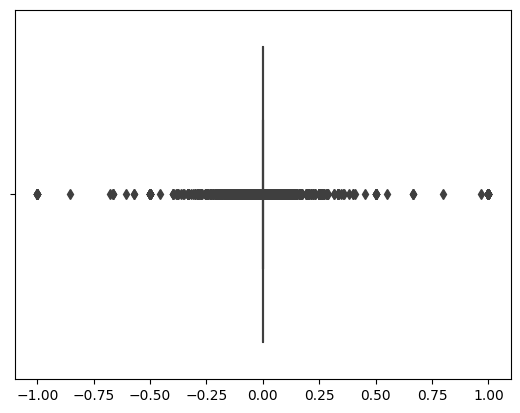

In [71]:
diff = filt_menderr['out_count_pct'] - filt_menderr['in_count_pct']
sb.boxplot(diff)
diff.describe()

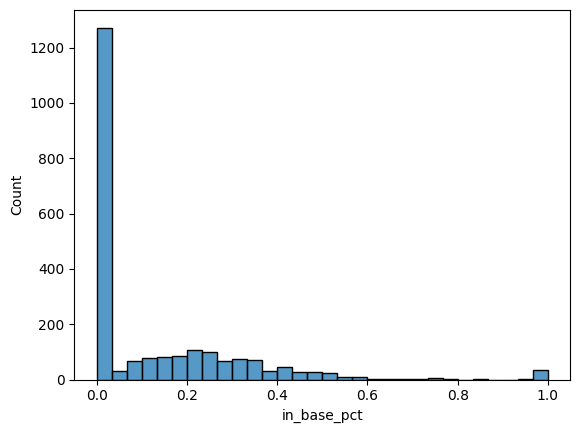

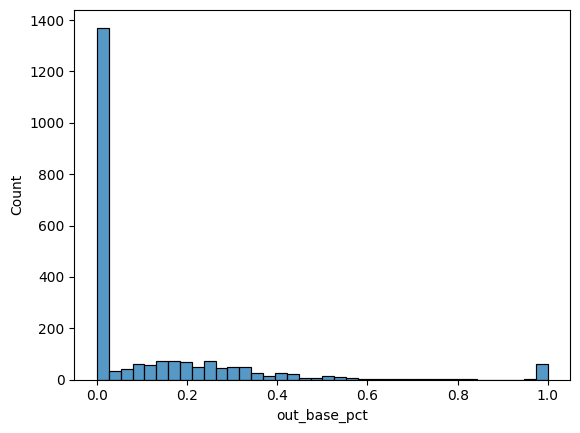

In [14]:
sb.histplot(data=filt_menderr, x="in_base_pct")
plt.show()
sb.histplot(data=filt_menderr, x="out_base_pcxt")
plt.show()

In [54]:
filt_menderr[filt_menderr['out_base_pct'] == 1].sample(5)

,in_count_pct,in_base_pct,out_count_pct,out_base_pct,has_change
region,,,,,
chr20:19285452-19285592,0.500000,0.500000,1.0,1.0,True
chr20:29664406-29664515,0.000000,0.000000,1.0,1.0,True
chr20:45859399-45859465,0.333333,0.411765,1.0,1.0,True
chr20:26049072-26049163,0.000000,0.000000,1.0,1.0,True
chr20:62288300-62288651,0.000000,0.000000,1.0,1.0,True


In [55]:
data['chr20:19285452-19285592']

{'in': {'var_count': 5,
  'var_bases': 31,
  'var_positions': 1,
  'allele_counts': [1, 1, 1, 6, 3],
  'menderr': array([[0., 0., 0., 0., 0.],
         [1., 5., 0., 0., 0.],
         [1., 5., 1., 5., 0.]]),
  'consis': array([[1., 5., 1., 5., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]])},
 'out': {'var_count': 4,
  'var_bases': 30,
  'var_positions': 1,
  'allele_counts': [6, 4, 1, 1],
  'menderr': array([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 5., 1., 5., 0.]]),
  'consis': array([[1., 5., 1., 5., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 6., 1., 6., 0.]])},
 'inTR': [['A', -8.0], ['A', -7.0], ['A', -6.0], ['A', -5.0], ['A'

# Non-Singleton Variants

In [56]:
rows = []
for k, reg in data.items():
    if isinstance(reg['in'], str) or isinstance(reg['out'], str):
        continue
    in_max_ac = max(reg['in']['allele_counts']) if reg['in']['allele_counts'] else np.nan
    out_max_ac = max(reg['out']['allele_counts']) if reg['out']['allele_counts'] else np.nan
    
    in_non_single = len([_ for _ in reg['in']['allele_counts'] if _ > 1])
    out_non_single = len([_ for _ in reg['out']['allele_counts'] if _ > 1])
    
    if reg['in']['var_count'] != 0:
        in_non_single_pct = in_non_single / reg['in']['var_count']
    else:
        in_non_single_pct = np.nan

    if reg['out']['var_count'] != 0:
        out_non_single_pct = out_non_single / reg['out']['var_count']
    else:
        out_non_single_pct = np.nan
    if reg['in']['allele_counts']:
        in_mean_af = np.mean([_ / 172 for _ in reg['in']['allele_counts']])
    else:
        in_mean_af = np.nan
    if reg['out']['allele_counts']:
        out_mean_af = np.mean([_ / 172 for _ in reg['out']['allele_counts']])
    else:
        out_mean_af = np.nan
    rows.append([k, in_max_ac, out_max_ac, 
                 in_non_single, out_non_single, 
                 in_non_single_pct, out_non_single_pct,
                in_mean_af, out_mean_af])
max_ac = pd.DataFrame(rows, columns=["key", "in_max_ac", "out_max_ac", 
                                     "in_non_single", "out_non_single",
                                    "in_ns_pct", "out_ns_pct", "in_mean_af", "out_mean_af"])
max_ac.set_index('key', inplace=True)

In [57]:
max_ac.loc[counts[keep].index].describe()

,in_max_ac,out_max_ac,in_non_single,out_non_single,in_ns_pct,out_ns_pct,in_mean_af,out_mean_af
count,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000,4156.000000
mean,30.589990,38.473773,7.043311,8.685996,0.568627,0.586724,0.051159,0.063579
std,30.773687,38.296136,7.803887,16.436152,0.268098,0.285714,0.064568,0.091996
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005814,0.005814
25%,8.000000,9.000000,2.000000,2.000000,0.416667,0.401805,0.015504,0.017091
50%,21.000000,26.000000,4.000000,4.000000,0.571429,0.600000,0.030579,0.035714
75%,43.000000,56.000000,9.000000,10.000000,0.750000,0.800000,0.060773,0.072093
max,172.000000,172.000000,88.000000,379.000000,1.000000,1.000000,0.947674,1.000000


<AxesSubplot: xlabel='variable', ylabel='value'>

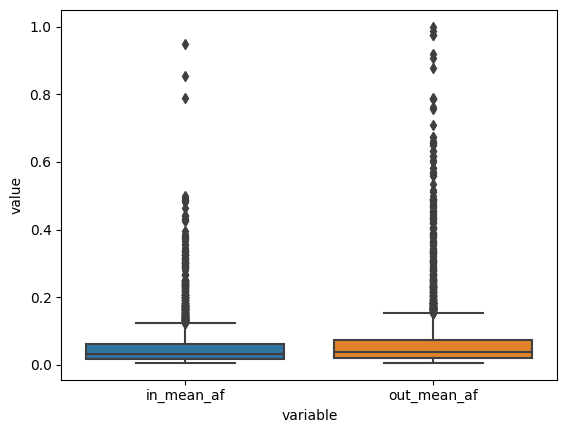

In [58]:
view = max_ac.loc[counts[keep].index]
view = pd.melt(view[view["in_mean_af"] != view["out_mean_af"]], value_vars=['in_mean_af', 'out_mean_af'])
sb.boxplot(data=view, x='variable', y='value')

[(0.0, 0.15)]

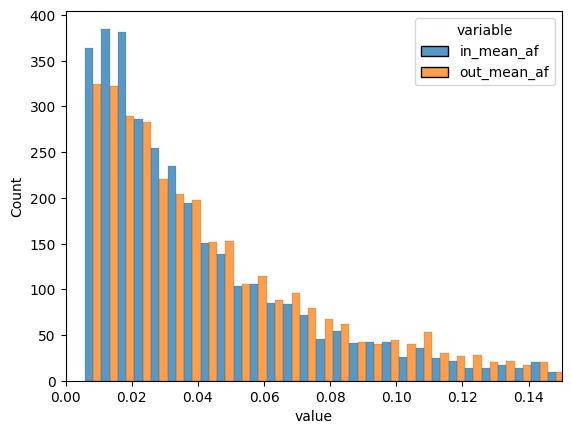

In [59]:
p = sb.histplot(data=view, hue='variable', x='value', binwidth=0.005, multiple='dodge')
p.set(xlim=(0, 0.15))

In [25]:
counts[keep].head()

,in_var_count,out_var_count,in_var_positions,out_var_positions,in_var_bases,out_var_bases
region,,,,,,
chr20:35791382-35791625,15,11,9,4,171,126
chr20:34113205-34114548,3,1,3,1,525,515
chr20:55712390-55712729,1,14,1,14,5,179
chr20:47656863-47656936,17,18,5,1,212,213
chr20:24323286-24323379,5,4,2,1,56,48


# Annotations

In [74]:
import random
random.sample(data.keys(), 5)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_93347/1937798894.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(data.keys(), 5)


['chr20:63372065-63372691',
 'chr20:5251051-5251172',
 'chr20:34784199-34784260',
 'chr20:47256049-47256110',
 'chr20:63697745-63697921']

In [76]:
data['chr20:63372065-63372691']

{'in': {'var_count': 27,
  'var_bases': 4357,
  'var_positions': 25,
  'allele_counts': [2,
   1,
   69,
   1,
   12,
   2,
   1,
   1,
   24,
   1,
   1,
   1,
   7,
   1,
   1,
   1,
   1,
   2,
   1,
   1,
   1,
   1,
   1,
   8,
   1,
   1,
   1],
  'menderr': array([[  6., 997.,   2., 372.,   0.],
         [  3., 481.,   0.,   0.,   0.],
         [  2., 259.,   0.,   0.,   0.]]),
  'consis': array([[  1., 111.,   1., 111.,   0.],
         [  1., 185.,   1., 185.,   0.],
         [  1., 185.,   1., 185.,   0.],
         [  1., 185.,   1., 185.,   0.],
         [  2., 296.,   2., 296.,   0.],
         [  0.,   0.,   0.,   0.,   0.],
         [  1., 185.,   1., 185.,   0.],
         [  2., 333.,   2., 333.,   0.]])},
 'out': {'var_count': 30,
  'var_bases': 1984,
  'var_positions': 26,
  'allele_counts': [1,
   1,
   1,
   1,
   1,
   4,
   1,
   1,
   2,
   1,
   1,
   1,
   7,
   1,
   1,
   1,
   1,
   1,
   1,
   87,
   1,
   1,
   8,
   7,
   5,
   14,
   14,
   1,
   37,
   1],